In [1]:
import sys
sys.path.append("../")

from smc.sampler import SMCsampler
from smc.prior import ParetoStarPrior
from smc.images import ImageModel
from smc.kernel import SingleComponentMH
from smc.aggregate import Aggregate

import torch

import matplotlib.pyplot as plt
import numpy as np

from utils.misc import select_cuda_device

device = select_cuda_device()
torch.cuda.set_device(device)
torch.set_default_device(device)

Selected device 0, which has 11004 MB available.


We generate an 8x8 image with at most 10 stars:

Number of stars including padding: 7
Number of stars within image boundary: 5
Total intrinsic flux of all stars (including padding): 7051.0
Total intrinsic flux of stars within image boundary: 3613.0
Total observed flux: 17430.0


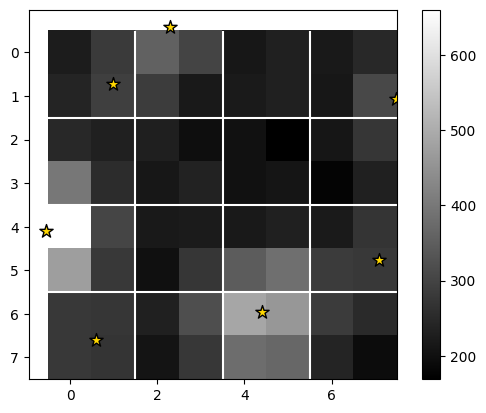

In [2]:
torch.manual_seed(121)

image_dim = 8

psf_stdev = 0.93
psf_max = 1 / (2 * np.pi * (psf_stdev**2))

background = 200

max_objects = 10

flux_scale = 5 * np.sqrt(background) / psf_max
flux_alpha = (-np.log(1 - 0.99)) / (
    np.log(50 * np.sqrt(background) / psf_max) - np.log(flux_scale)
)

quantile01_flux = flux_scale * ((1-0.05) ** (-1/flux_alpha))
pad = np.sqrt(- 2 * (psf_stdev**2) * np.log(flux_scale/quantile01_flux))

TruePrior = ParetoStarPrior(max_objects = max_objects,
                            image_height = image_dim,
                            image_width = image_dim,
                            flux_scale = flux_scale,
                            flux_alpha = flux_alpha,
                            pad = pad)

TrueImageModel = ImageModel(image_height = image_dim,
                            image_width = image_dim,
                            psf_stdev = psf_stdev,
                            background = background)

(unpruned_counts, unpruned_locs, unpruned_fluxes,
 pruned_counts, pruned_locs, pruned_fluxes, images) = TrueImageModel.generate(Prior = TruePrior,
                                                                      num_images = 1)

print(f'Number of stars including padding: {unpruned_counts[0]}')
print(f'Number of stars within image boundary: {pruned_counts[0]}')
print(f'Total intrinsic flux of all stars (including padding): {unpruned_fluxes[0].sum(-1).round()}')
print(f'Total intrinsic flux of stars within image boundary: {pruned_fluxes[0].sum(-1).round()}')
print(f'Total observed flux: {images[0].sum().round()}')

fig, ax = plt.subplots(1,1)
tmp = ax.imshow(images[0].cpu(), cmap = 'gray')
_ = fig.colorbar(tmp)
_ = ax.scatter(unpruned_locs.squeeze()[:unpruned_counts.squeeze(),1].cpu() - 0.5,
               unpruned_locs.squeeze()[:unpruned_counts.squeeze(),0].cpu() - 0.5,
               marker = '*', color = 'gold', edgecolors = 'black', s = 100)
_ = ax.vlines(x = image_dim//4 - 0.5, ymin = 0 - 0.5, ymax = image_dim - 0.5, color = 'white')
_ = ax.vlines(x = 2*image_dim//4 - 0.5, ymin = 0 - 0.5, ymax = image_dim - 0.5, color = 'white')
_ = ax.vlines(x = 3*image_dim//4 - 0.5, ymin = 0 - 0.5, ymax = image_dim - 0.5, color = 'white')
_ = ax.hlines(y = image_dim//4 - 0.5, xmin = 0 - 0.5, xmax = image_dim - 0.5, color = 'white')
_ = ax.hlines(y = 2*image_dim//4 - 0.5, xmin = 0 - 0.5, xmax = image_dim - 0.5, color = 'white')
_ = ax.hlines(y = 3*image_dim//4 - 0.5, xmin = 0 - 0.5, xmax = image_dim - 0.5, color = 'white')

We will run an SMC sampler to generate catalogs for the entire image (without tiles, for now). We assume that we have access to the true prior and image model. We also specify a Metropolis-Hastings kernel to be used within the SMC sampler.

In [3]:
tile_dim = 8

TilePrior = ParetoStarPrior(max_objects = 12,
                            image_height = tile_dim,
                            image_width = tile_dim,
                            flux_scale = flux_scale,
                            flux_alpha = flux_alpha,
                            pad = pad)

TileImageModel = ImageModel(image_height = tile_dim,
                            image_width = tile_dim,
                            psf_stdev = psf_stdev,
                            background = background)

MHKernel = SingleComponentMH(num_iters = 100,
                             locs_stdev = 0.25,
                             fluxes_stdev = 250,
                             fluxes_min = flux_scale,
                             fluxes_max = 1e9)

We initialize an `SMCsampler` and run it on the tiles.

In [4]:
sampler = SMCsampler(image = images[0],
                     tile_dim = tile_dim,
                     Prior = TilePrior,
                     ImageModel = TileImageModel,
                     MutationKernel = MHKernel,
                     num_catalogs_per_count = 2000,
                     ess_threshold_prop = 0.5,
                     resample_method = "multinomial",
                     max_smc_iters = 100,
                     print_every = 2)

sampler.run()

starting the tile samplers...
iteration 2: temperature in [0.01, 0.01], acceptance rate in [0.61, 0.61]
iteration 4: temperature in [0.01, 0.01], acceptance rate in [0.63, 0.63]
iteration 6: temperature in [0.02, 0.02], acceptance rate in [0.64, 0.64]
iteration 8: temperature in [0.05, 0.05], acceptance rate in [0.58, 0.58]
iteration 10: temperature in [0.09, 0.09], acceptance rate in [0.51, 0.51]
iteration 12: temperature in [0.14, 0.14], acceptance rate in [0.44, 0.44]
iteration 14: temperature in [0.25, 0.25], acceptance rate in [0.38, 0.38]
iteration 16: temperature in [0.42, 0.42], acceptance rate in [0.32, 0.32]
iteration 18: temperature in [0.7, 0.7], acceptance rate in [0.26, 0.26]
done!



We can estimate the posterior probability of each source count (including sources in the padded region) by taking the softmax of the estimated log normalizing constants:

In [5]:
print(sampler.counts.unique().cpu())
print(sampler.log_normalizing_constant.squeeze([0,1]).softmax(-1).round(decimals=3).cpu())

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.])
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0310, 0.1570, 0.4640,
        0.2940, 0.0390, 0.0140, 0.0010], dtype=torch.float64)


Now we instantiate an `Aggregate` object and resample the catalogs we sampled above. The `Aggregate` object isn't doing much work here at all, but it's helpful when we run our procedure on images partitioned into tiles.

In [6]:
aggMH = SingleComponentMH(num_iters = 50,
                          locs_stdev = 0.1,
                          fluxes_stdev = 50,
                          fluxes_min = flux_scale,
                          fluxes_max = 1e9)

In [7]:
agg = Aggregate(sampler.Prior,
                sampler.ImageModel,
                aggMH,
                sampler.tiled_image,
                sampler.counts,
                sampler.locs,
                sampler.fluxes,
                sampler.weights_intercount,
                sampler.log_normalizing_constant,
                ess_threshold_prop = 0.5,
                resample_method = "multinomial")

agg.run()

aggregating tile catalogs...
done!



We summarize our results by reporting the posterior distribution over the number of stars within the image boundaries and the posterior mean of the total intrinsic flux:

In [8]:
agg.summarize()

summary:

posterior distribution of number of stars including padding:
tensor([ 6.,  7.,  8.,  9., 10., 11., 12.])
tensor([0.0310, 0.1590, 0.4660, 0.2920, 0.0390, 0.0120, 0.0010]) 

posterior distribution of number of stars within image boundary:
tensor([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11])
tensor([0.0000, 0.0180, 0.1130, 0.2840, 0.3260, 0.2000, 0.0520, 0.0060, 0.0010,
        0.0000]) 

posterior mean total intrinsic flux including padding = 7415.0

posterior mean total intrinsic flux within boundary = 3828.0

number of unique catalogs = 7328


We can examine the posterior predictive distribution of the total observed flux. The dotted black line is the true total observed flux, computed by summing the intensities of all the pixels in the image. We expect 

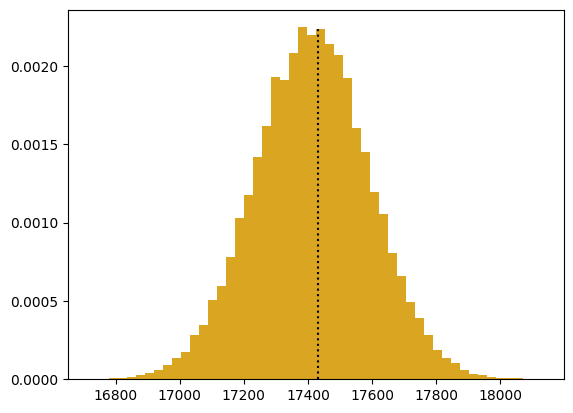

In [9]:
tmp = plt.hist(agg.posterior_predictive_total_observed_flux.squeeze().cpu(), bins = 50, density = True, color = 'goldenrod')
_ = plt.vlines(x = images[0].sum().cpu(), ymin = 0, ymax = tmp[0].max(), color = 'black', linestyle = 'dotted')

We can also examine the posterior distribution of the total intrinsic flux of all of the detected stars in each catalog (including those in the padding). The dotted black line is the ground truth. We expect posterior intervals of this distribution to achieve nominal frequentist coverage.

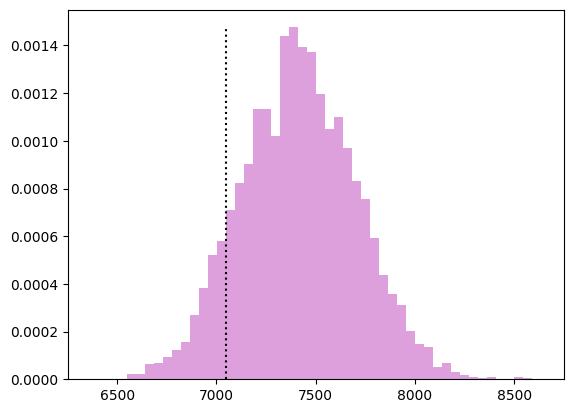

In [10]:
tmp = plt.hist(agg.fluxes.squeeze().sum(-1).cpu(), bins = 50, density = True, color = 'plum')
_ = plt.vlines(x = unpruned_fluxes.sum(-1).cpu(), ymin = 0, ymax = tmp[0].max(), color = 'black', linestyle = 'dotted')

We can also examine the posterior distribution of the total intrinsic flux of stars within the image boundary. The dotted black line is the ground truth. For images with stars near the boundary, this distribution will be multimodal. For each catalog, the total intrinsic flux within the boundary will depend on the locations of the stars near the boundary. We still expect credible intervals based on this distribution to achieve nominal frequentist coverage in the limit of infinite samples, but some modes may not be characterized well unless the number of samples is large.

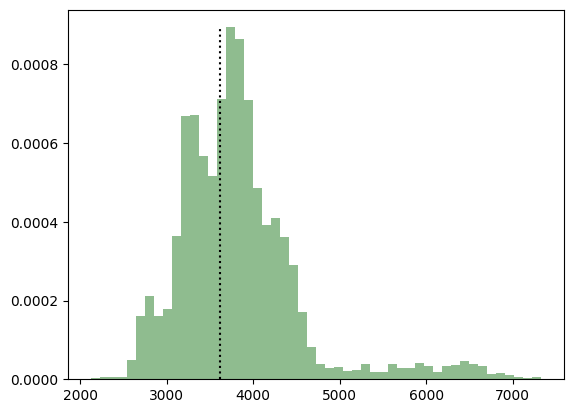

In [11]:
tmp = plt.hist(agg.pruned_fluxes.squeeze().sum(-1).cpu(), bins = 50, density = True, color = 'darkseagreen')
_ = plt.vlines(x = pruned_fluxes.sum(-1).cpu(), ymin = 0, ymax = tmp[0].max(), color = 'black', linestyle = 'dotted')

We can also reconstruct the image using a few of our posterior samples:

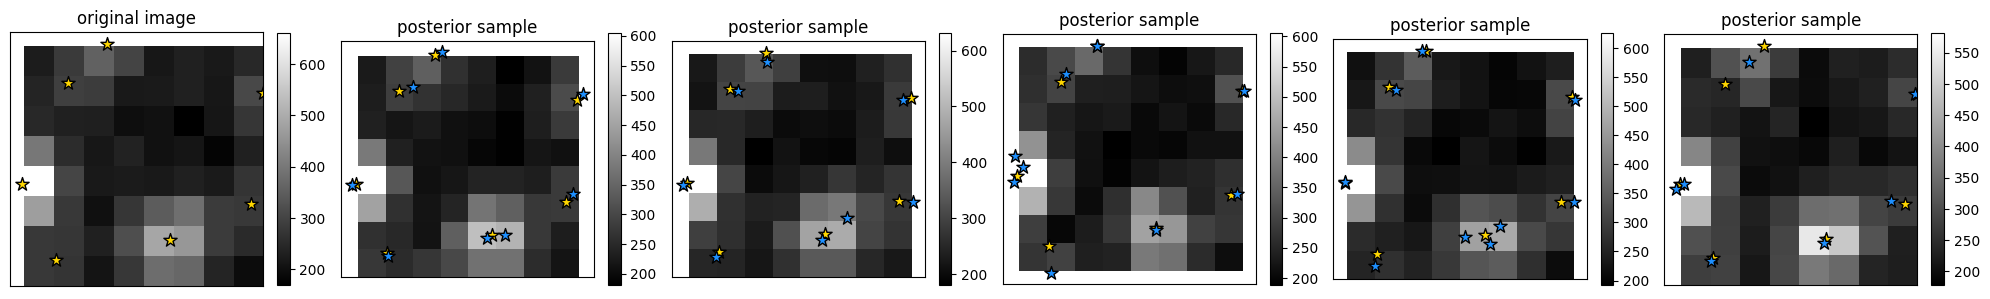

In [12]:
fig, ax = plt.subplots(1, 6, figsize = (20,4))
tmp = ax[0].imshow(images[0].cpu(), cmap = 'gray')
_ = fig.colorbar(tmp, fraction = 0.045)
_ = ax[0].set_title('original image')
_ = ax[0].scatter(unpruned_locs.squeeze()[:unpruned_counts.squeeze(),1].cpu() - 0.5,
                  unpruned_locs.squeeze()[:unpruned_counts.squeeze(),0].cpu() - 0.5,
                  marker = '*', color = 'gold', edgecolors = 'black', s = 100)
_ = ax[0].set_xticks([])
_ = ax[0].set_yticks([])

for j in range(1,6):
    index = torch.randint(low = 0, high = agg.counts.shape[-1] - 1, size = [1])
    psf = agg.ImageModel.psf(agg.locs.detach()[:,:,index])
    rate = (psf * agg.fluxes[:,:,index].unsqueeze(-3).unsqueeze(-4)).sum(-1) + agg.ImageModel.background
    reconstruction = torch.distributions.Poisson(rate).sample().squeeze([0,1]).permute((2,0,1))
    tmp = ax[j].imshow(reconstruction[0].cpu(), cmap = 'gray')
    _ = ax[j].set_title('posterior sample')
    _ = fig.colorbar(tmp, fraction = 0.045)
    _ = ax[j].scatter(unpruned_locs.squeeze()[:unpruned_counts.squeeze(),1].cpu() - 0.5,
                      unpruned_locs.squeeze()[:unpruned_counts.squeeze(),0].cpu() - 0.5,
                    marker = '*', color = 'gold', edgecolors = 'black', s = 100)
    _ = ax[j].scatter(agg.locs.detach().squeeze()[index,:agg.counts.squeeze()[index].int(),1].cpu() - 0.5,
                    agg.locs.detach().squeeze()[index,:agg.counts.squeeze()[index].int(),0].cpu() - 0.5,
                    marker = '*', color = 'dodgerblue', edgecolors = 'black', s = 100)
    _ = ax[j].set_xticks([])
    _ = ax[j].set_yticks([])

fig.tight_layout()

To assess the locations of light sources in our posterior catalogs, we plot a two-dimensional density plot of these locations and overlay them on the image:

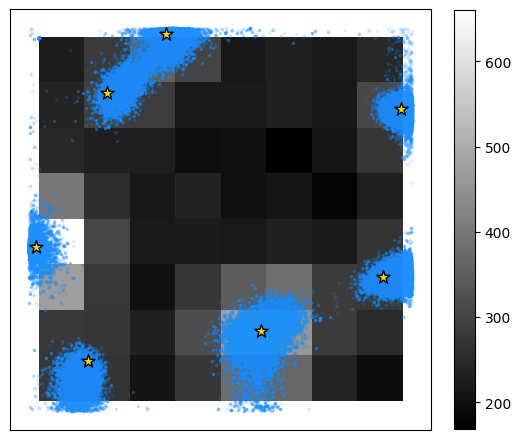

In [13]:
fig, ax = plt.subplots(1, 1, figsize = (6, 6))
tmp = ax.imshow(images[0].cpu(), cmap = 'gray')
_ = fig.colorbar(tmp, fraction = 0.045)
_ = ax.scatter(agg.locs.detach().squeeze()[...,1].cpu() - 0.5,
               agg.locs.detach().squeeze()[...,0].cpu() - 0.5,
               marker = '.', color = 'dodgerblue', s = 10, alpha = 0.1)
_ = ax.scatter(unpruned_locs.squeeze()[:unpruned_counts.squeeze(),1].cpu() - 0.5,
               unpruned_locs.squeeze()[:unpruned_counts.squeeze(),0].cpu() - 0.5,
               marker = '*', color = 'gold', edgecolors = 'black', s = 100)
_ = ax.set_xticks([])
_ = ax.set_yticks([])

If we only care about stars within the image boundary, we can exclude stars outside the boundary and overlay the "pruned" catalogs:

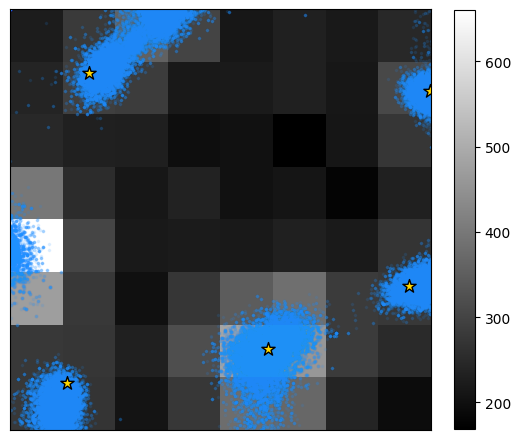

In [14]:
fig, ax = plt.subplots(1, 1, figsize = (6, 6))
tmp = ax.imshow(images[0].cpu(), cmap = 'gray')
_ = fig.colorbar(tmp, fraction = 0.045)
_ = ax.scatter(agg.pruned_locs.squeeze()[...,1].cpu() - 0.5,
               agg.pruned_locs.squeeze()[...,0].cpu() - 0.5,
               marker = '.', color = 'dodgerblue', s = 10, alpha = 0.1)
_ = ax.scatter(pruned_locs.squeeze()[:pruned_counts.squeeze(),1].cpu() - 0.5,
               pruned_locs.squeeze()[:pruned_counts.squeeze(),0].cpu() - 0.5,
               marker = '*', color = 'gold', edgecolors = 'black', s = 100)
_ = ax.set_xticks([])
_ = ax.set_yticks([])